In [1]:
"""
!pip install mss
!pip install matplotlib
!pip install tensorboardX python-dotenv
"""

'\n!pip install mss\n!pip install matplotlib\n!pip install tensorboardX python-dotenv\n'

## preparations

In [2]:
# debug
import time
import random
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [3]:
import os
from dotenv import load_dotenv

EXECUTABLE_NAME = os.getenv('EXECUTABLE_NAME')
GAME_WINDOW_NAME = os.getenv('GAME_WINDOW_NAME')

### camera

In [4]:
from src.gamenv import GameEnv

game_env = GameEnv("snes9x.exe", "mario - Snes9x 1.62.3", (20, 120, -10, -50))
camera = game_env.camera

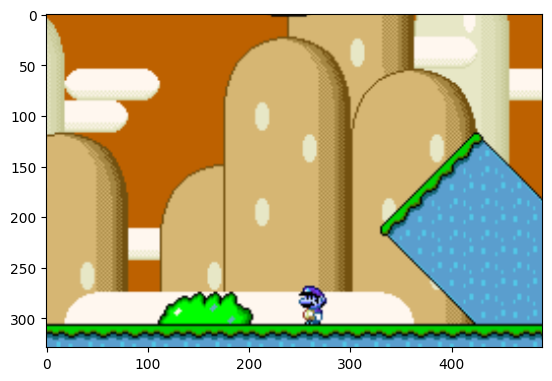

In [5]:
camera.set_foreground_game()
frame = camera.get_frame()
plt.imshow(frame)

### Agent

In [6]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
D = 40_000
GAMMA = 0.99
LR = 0.0003

# NUM_EPISODES = 10000
SEQUENCE_LENGTH = 50
BATCH_SIZE = 50

EPS_NUM_STEPS = 2000
EPS_START = 0.1
EPS_END = 0.01
EPS_DECAY = (EPS_START - EPS_END) / (EPS_NUM_STEPS)

action_space = 3 # 4

load_model = False
model_name = "2023_12_26_23_13_56"

In [8]:
import time
from itertools import count
from tensorboardX import SummaryWriter

from src.memory import Memory

timestr = time.strftime("%Y_%m_%d_%H_%M_%S")

In [9]:
# Initiliaze replay memory D to capacity N
replay_memory = Memory(D)
sequence = Memory(SEQUENCE_LENGTH)

In [10]:
from src.models.batch_model import DQN, phi
from torch import nn

# Initialize action-value function Q with random weights

lstm_n = 512
lstm_layers = 1

policy_net = DQN(action_space, lstm_n, lstm_layers).to(device) # used to store teta
target_net = DQN(action_space, lstm_n, lstm_layers).to(device) # used to store teta-1

if load_model:
    policy_net.load_state_dict(torch.load(f'./saved_models/{model_name}/policy_net'))
    
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.RMSprop(policy_net.parameters(), lr=LR)
loss_fn = nn.MSELoss()

global steps
steps = 0
episode = 0

(120, 200, 3)
tensor([1.2763e-07, 8.9804e-08, 8.8056e-08], device='cuda:0') tensor([1., 1., 1.], device='cuda:0')


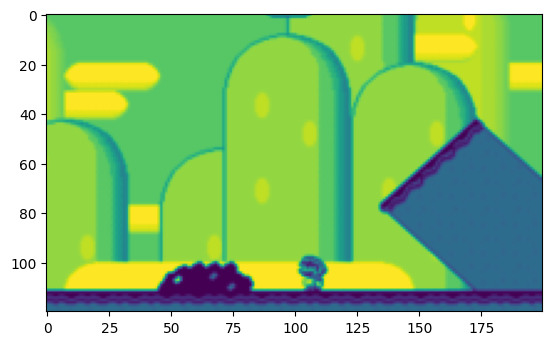

In [11]:
camera.set_foreground_game()
frame = camera.get_frame()
img = phi(observation=frame, device=device)
mean, std = img.mean([1,2]), img.std([1,2])
img = img.cpu().numpy()
img = img.transpose((1,2,0))
print(img.shape)
print(mean, std)
plt.imshow(img[:,:,0])

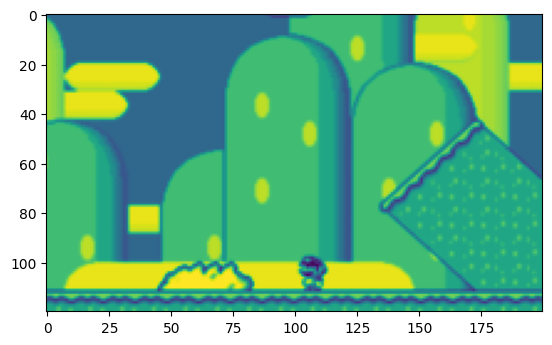

In [12]:
plt.imshow(img[:,:,1])

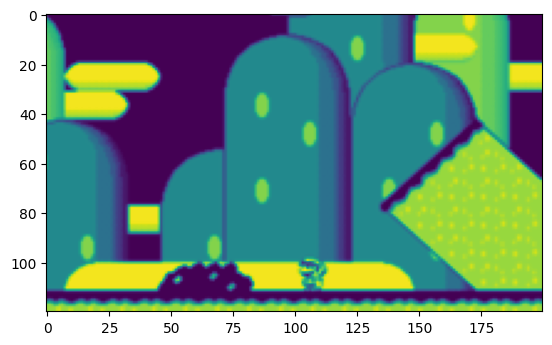

In [13]:
plt.imshow(img[:,:,2])

In [14]:
def assert_sequence(sequence: Memory):
    if len(sequence) == SEQUENCE_LENGTH:
        sequence_state = sequence.render_simple()
        for i in range(len(sequence_state)):
            print(f"{i}")
            plt.imshow(sequence_state[i].cpu().numpy().transpose((1,2,0)))
            plt.show()
        input()

In [15]:
import datetime

loss = 0
policy_net.train()
writer = SummaryWriter(logdir="runs/"+timestr)

global thread_running
thread_running = False
def play():
    global thread_running
    episode = 0
    epsilon = EPS_START
    steps = 0
    time.sleep(2)
    camera.set_foreground_game()
    time.sleep(0.2)
    # with SummaryWriter(logdir="runs/"+timestr) as writer:
    try:
        while steps < D*50-50:
            ep_rewards = 0
            ep_qvalues = 0
            ep_loss = 0
            
            # Initialise sequence s1 = {x1} and preprocessed sequenced φ1 = φ(s1)
            observation = game_env.reset()
            state = phi(observation, device)
            last_reward = 0
            # sequence.clear()
            
            print(thread_running)
            if not thread_running:
                return
            
            for t in count():
                step_time_start = time.perf_counter()
                # print(len(sequence), t)

                sequence.push(state)
                sequence_state = sequence.render_simple()

                # assert_sequence(sequence)

                hn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)
                cn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)

                with torch.no_grad():
                    
                    q_value_action, (hn, cn) = policy_net(sequence_state, (hn, cn))
                    q_value_action = q_value_action[-1:]
                    q_value_action = q_value_action.max(1)
                    q_value = q_value_action[0].item()
                    ep_qvalues += q_value
                
                # With probability eps select a random action at
                epsilon = epsilon - EPS_DECAY if epsilon > EPS_END else EPS_END
                if random.uniform(0, 1) < epsilon:
                    action = torch.tensor([[random.randint(0, action_space-1)]], device=device, dtype=torch.long)
                # otherwise select at = maxaQ*(phi(st), a; teta)
                else:
                    action = q_value_action[1].view(1,1)
                    # print(action)

                # Execute action at in emulator and observe reward rt and image xt+1
                observation, reward, game_over = game_env.step(action.item())
                
                ep_rewards += reward
                #print(reward)
                reward = torch.tensor([reward], device=device, dtype=torch.float32)

                # Set st+1 = st, at, xt+1 and preprocess phit+1 = phi(st+1)
                if game_over:
                    next_state = None # ordem provavelmente errada
                else:
                    next_state = phi(observation, device)
                    # sequence.push(next_state)
                    # rendered, next_sequence_state = sequence.render()

                #if sequence_state != None:
                #    replay_memory.push((sequence_state, action, reward, next_sequence_state))
                replay_memory.push((state, action, reward, next_state))
                
                # writer
                writer.add_scalar("Reward/reward", reward, steps)
                writer.add_scalar("Qvalue/qvalue", q_value, steps)
                writer.add_scalar("Steps/Execution_Time", (time.perf_counter() - step_time_start), steps)
                writer.add_scalar("Epsilon/epsilon", epsilon, steps)
                writer.flush()
                
                # adding ep log
                ep_rewards += reward

                # sequence_state = next_sequence_state 
                state = next_state
                steps += 1
                if game_over:
                    
                    # ep log
                    ep_reward_mean = ep_rewards / (t+1)
                    writer.add_scalar("Episode/reward_mean", ep_reward_mean, episode)

                    break
            episode += 1
            # writer.flush()
    except Exception as e:
        print(e)
        thread_running = False
    
def train():
    global thread_running
    train_steps = 0
    while True:
        if not thread_running:
            return
        if len(replay_memory) > BATCH_SIZE: # and steps > 200:
            loss = policy_net.q_train(target_net, optimizer, loss_fn, replay_memory.sample_sequence(BATCH_SIZE), GAMMA, lstm_n, lstm_layers, device).item()
            # ep_loss += loss
            writer.add_scalar("Loss/loss", loss, train_steps)
            """if (t+1) % SEQUENCE_LENGTH == 0:

                clear_output(wait=True)
                print('loss:', ep_loss, 'step:', steps, 'epsilon:', epsilon, 'last_reward:', ep_rewards, 'ep:', episode)
                writer.add_scalar("Loss/ep_loss", ep_loss / SEQUENCE_LENGTH, steps)
                writer.add_scalar("Reward/ep_rewards", ep_rewards / SEQUENCE_LENGTH, steps)
                writer.add_scalar("Qvalue/ep_qvalues", ep_qvalues / SEQUENCE_LENGTH, steps)
                ep_rewards = 0
                ep_qvalues = 0
                ep_loss = 0
            """
            clear_output(wait=True)
            print(f"loss: {loss}")
            if train_steps % 3_000 == 0:
                target_net.load_state_dict(policy_net.state_dict())
            train_steps += 1
        else:
            print("dont have sufficient memory to train...")
            time.sleep(1)


In [16]:
import threading

play_thread = threading.Thread(target=play, daemon=True)
train_thread = threading.Thread(target=train, daemon=True)

thread_running = True

play_thread.start()
train_thread.start()
print("threads started...")

play_thread.join()
train_thread.join()
print("threads ended.")

loss: 0.015763606876134872
threads ended.


In [17]:
from src.models.batch_model import prompt_conv
sequence_state = replay_memory.sample_sequence(5)
print(len(sequence_state[0]))
# sequence_state = sequence.render_simple()
print(sequence_state[0])
prompt_conv(sequence_state)

4
(tensor([[[ 0.6886,  0.6886,  0.6886,  ..., -0.0536, -0.0536, -0.0536],
         [ 0.6886,  0.6886,  0.6886,  ..., -0.0536, -0.0536, -0.0536],
         [ 0.6886,  0.6886,  0.6886,  ..., -0.0536, -0.0536, -0.0536],
         ...,
         [-1.9013, -2.1954, -2.2938,  ..., -1.9188, -2.2188, -2.2975],
         [-1.8041, -1.8113, -1.8498,  ..., -1.8049, -1.8124, -1.8267],
         [-1.8029, -1.8029, -1.8493,  ..., -1.8035, -1.8044, -1.8482]],

        [[ 1.0998,  1.0998,  1.0998,  ..., -1.0556, -1.0556, -1.0556],
         [ 1.0998,  1.0998,  1.0998,  ..., -1.0556, -1.0556, -1.0556],
         [ 1.0998,  1.0998,  1.0998,  ..., -1.0556, -1.0556, -1.0556],
         ...,
         [-0.1454, -0.3603, -0.4062,  ..., -0.1586, -0.3777, -0.4523],
         [-0.0753, -0.0805,  0.0857,  ..., -0.0734, -0.0792, -0.0293],
         [-0.0744, -0.0744,  0.1424,  ..., -0.0715, -0.0684,  0.1229]],

        [[ 1.0451,  1.0451,  1.0451,  ..., -1.0602, -1.0602, -1.0602],
         [ 1.0451,  1.0451,  1.0451,  ...,

AttributeError: 'list' object has no attribute 'shape'

In [ ]:

import os

save_model_dir = './saved_models'

if not os.path.exists(f'{save_model_dir}'):
    os.mkdir(f'{save_model_dir}')
if not os.path.exists(f'{save_model_dir}/{timestr}'):
    os.mkdir(f'{save_model_dir}/{timestr}')

torch.save(policy_net.state_dict(), f'{save_model_dir}/{timestr}/policy_net')
torch.save(target_net.state_dict(), f'{save_model_dir}/{timestr}/target_net')

In [ ]:
def assert_memory():
    sequence = replay_memory.sample_sequence(3)

    states, actions, rewards, next_states = *zip(*sequence), # let the ',' to not give syntax error
    sequence_length = len(states) # - 1

    states = torch.stack(states)
    actions = torch.cat(actions)
    rewards = torch.cat(rewards)

    non_final_states_mask = torch.tensor(tuple(map(lambda s: s is not None, next_states)), device=device)
    non_final_next_states = torch.stack([s for s in next_states if s is not None])

    print(len(states))
    for i in range(len(states)):
        print(f"{i}")
        plt.imshow(states[i].cpu().numpy().transpose((1,2,0)))
        plt.show()
        plt.imshow(non_final_next_states[i].cpu().numpy().transpose((1,2,0)))
        plt.show()
assert_memory()

In [ ]:
exit()

In [ ]:
camera.set_foreground_game()

policy_net.eval()
while True:
    observation = game_env.reset()
    time.sleep(0.1)
    state = phi(observation, device)
    sequence.clear()
    
    for t in count():

        sequence.push(state)
        rendered = sequence.render_simple()

        hn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)
        cn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)
        with torch.no_grad():
            q_value_action, (hn, cn) = policy_net.forward_prompt(rendered, (hn, cn))
            q_value_action = q_value_action[-1:]
            print(q_value_action, end="")
            q_value_action = q_value_action.max(1)
            action = q_value_action[1].view(1,1)
            print(f", actions {action}")

        observation, reward, game_over = game_env.step(action.item())
        if game_over:
            next_state = None # ordem provavelmente errada
        else:
            next_state = phi(observation, device)
        state = next_state
        if game_over:
            break

In [ ]:
"""camera.set_foreground_game()
state = phi(camera.get_frame(), device)

policy_net.eval()
hn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)
cn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)

with torch.no_grad():
    q_value_action, (hn, cn) = policy_net(state.unsqueeze(0), (hn, cn))
    q_value_action = q_value_action[-1:]
    print(q_value_action)"""